# Running filtering/smoothing using KF, EKF and UKF

In [5]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [8]:
from bayesfilt.filters import KalmanFilter, ExtendedKalmanFilter, UnscentedKalmanFilter
from bayesfilt.models import ConstantVelocity, CTRA_POINT, LinearObservationModel

## 1. Generate ground truth and observation using CTRA model

In [9]:
# simulating ground truth
np.random.seed(30)
dt_true = 0.1
mm_true = CTRA_POINT()
mm_true.phi = {'sigma_omega': 0., 'sigma_accn':0., 'min_speed':0.}
mm_true.dt = dt_true
# mm_true
#mm_true.update_matrices()
tlen = 30
ncycles = 1
cur_x = np.array([0., 0., 0., 0., 0., 0.])
ttrue = np.linspace(0,tlen,int(tlen/dt_true)+1)
ytrue = []
for t in ttrue:
    cur_x[4] = 0.5*np.sin(2.0*np.pi*ncycles*t/tlen) + np.random.randn(1)*0.01
    cur_x[5] = 0.5*np.cos(2.0*np.pi*ncycles*t/tlen) + np.random.randn(1)*0.01
    cur_x = mm_true.func_f(cur_x)
    ytrue.append(cur_x)
ytrue = np.asarray(ytrue).T
vx = ytrue[3,:]*np.sin(ytrue[2,:])
vy = ytrue[3,:]*np.cos(ytrue[2,:])
ax = ytrue[5,:]*np.sin(ytrue[2,:])
ay = ytrue[5,:]*np.cos(ytrue[2,:])
ytrue = np.vstack([ytrue, vx, vy, ax, ay])

In [10]:
# generating synthetic observations
observed_states = [0,1]
noise_strengths = [0.1]*2
inds = np.sort(np.random.choice(list(range(1,ytrue.shape[1]-2)), size=int(ytrue.shape[1]/3), replace=False))
inds = np.hstack([0, inds, ytrue.shape[1]-1])
tobs = ttrue[inds].copy()
yobs = np.empty((len(observed_states), len(inds)))
for i, (ix, sigma) in enumerate(zip(observed_states, noise_strengths)):
    yobs[i,:] = ytrue[ix, inds] + np.random.randn(inds.size)*sigma

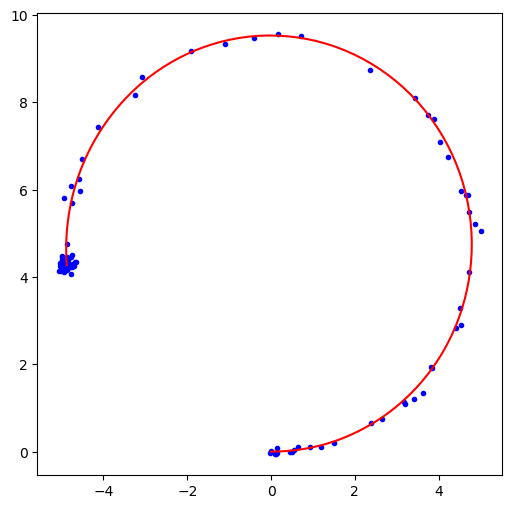

In [11]:
fig, ax = plt.subplots(figsize=(6,6))
ax.plot(yobs[0], yobs[1,:], '.b')
ax.plot(ytrue[0], ytrue[1,:], '-r')

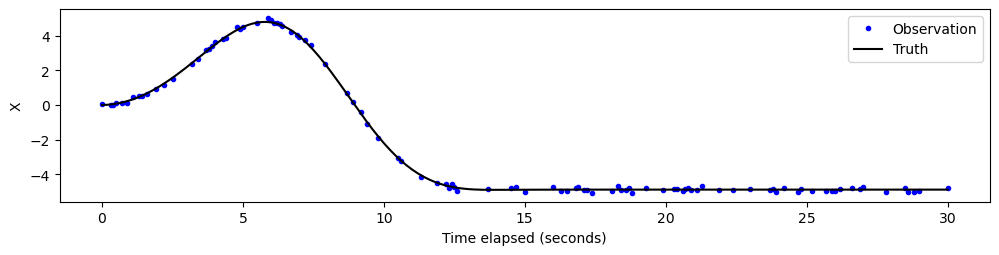

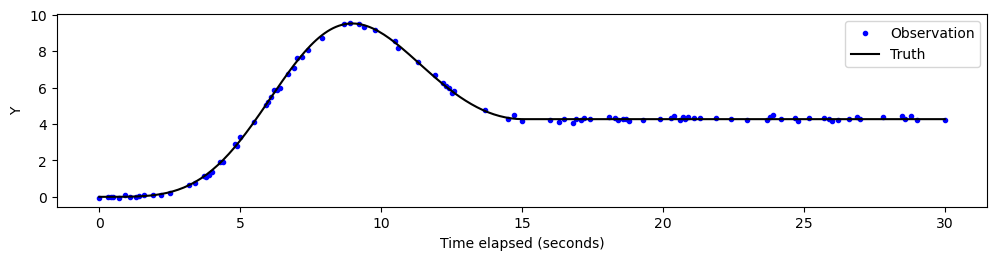

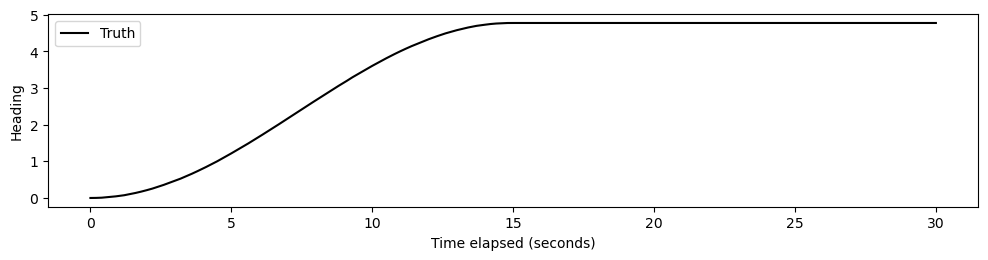

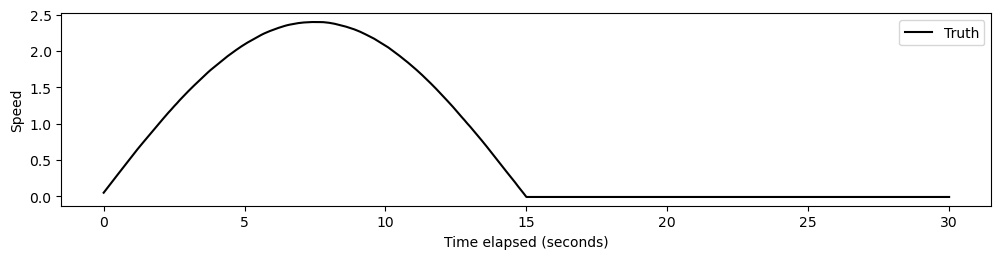

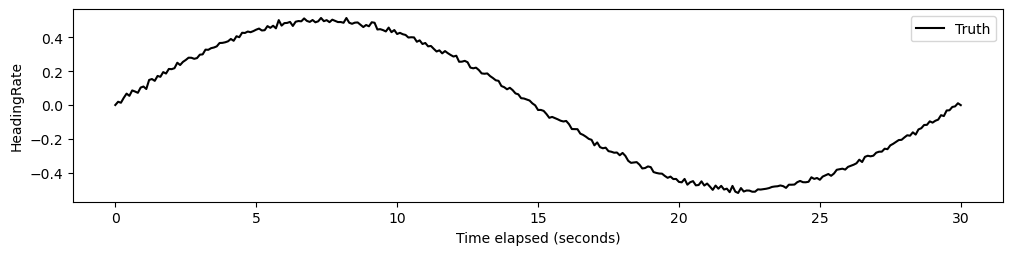

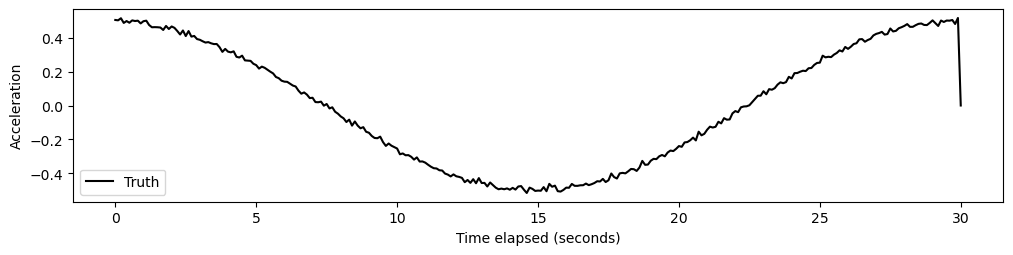

In [12]:
k = 0
for i, lbl in zip(range(mm_true.nx), mm_true.state_names):
    fig, ax = plt.subplots(figsize=(12,2.5))
    if i in observed_states:
        ax.plot(tobs,yobs[k,:], '.b', label='Observation')
        k += 1
    ax.plot(ttrue,ytrue[i,:], '-k', label='Truth')
    ax.set_ylabel(lbl)
    ax.set_xlabel('Time elapsed (seconds)')
    ax.legend()

## 2. Filter/Smoothing using KF, EKF and UKF

### Motion model

In [13]:
mm = ConstantVelocity(dof=2)
mm.dt = 0.1
mm.phi['sigmas'] = [0.25]*2
mm.update_matrices()
start_x = [yobs[0,0], 0.001, yobs[1,0], 0.001]
start_P = np.diag([0.1]*4)
# truth = {0:0, 1:7, 2:1, 3:6} # state-truth index pairs

In [14]:
print(mm)

----ConstantVelocity2D----
States    (4): PositionX_0,VelocityX_0,PositionX_1,VelocityX_1
Parameters(1): sigmas=[0.25, 0.25]
dt: 0.1 second



### Observation model

In [15]:
om = LinearObservationModel(nx=mm.nx, observed_state_inds=[0,2])
om.state_names = mm.state_names
om.R = np.diag([ix**2 for ix in [0.1]*2])
print(om)

----LinearObservationModel----
States    (4): PositionX_0,VelocityX_0,PositionX_1,VelocityX_1
Parameters(0): 
Obs States(2): PositionX_0,PositionX_1



### KF/KS

In [32]:
kf = KalmanFilter(nx=mm.nx, ny = om.ny, dt = mm.dt, mat_F = mm.F, mat_Q = mm.Q, 
                  mat_H=om.H, state_names=mm.state_names)
kf.R = om.R.copy()
kf.m = start_x
kf.P = start_P
kf.initiate(t0=tobs[0])
kf.filter(tobs[1:], [ix for ix in yobs[:,1:].T])
kf.smoother()
kf.df.head()
kf.metrics, kf.smetrics

KalmanFilter-Backward: 100%|██████████████████████████| 102/102 [00:00<00:00, 5121.86it/s]


(NIS       0.0
 NEES      0.0
 LogLik    0.0
 dtype: float64,
 NIS       0.0
 NEES      0.0
 LogLik    0.0
 dtype: float64)

In [26]:
from tqdm import trange, tqdm
for i, k in tqdm(enumerate([1,2,3]), total=3):
    print(i,k)

100%|████████████████████████████████████████████████████| 3/3 [00:00<00:00, 60205.32it/s]

0 1
1 2
2 3


### UKF/UKS

In [ ]:
ukf = UnscentedKalmanFilter(nx=mm.nx, ny = om.ny, dt = mm.dt, mat_F = mm.F, mat_Q = mm.Q, 
                  mat_H=om.H, state_names=mm.state_names, pars={'alpha':0.01, 'beta':0.})
ukf.R = om.R.copy()
ukf.m = start_x
ukf.P = start_P
ukf.initiate(t0=tobs[0])
ukf.filter(tobs[1:], [ix for ix in yobs[:,1:].T])
ukf.smoother()
ukf.df.head()
ukf.metrics, ukf.smetrics

### EKF/EKS

In [ ]:
ekf = ExtendedKalmanFilter(nx=mm.nx, ny = om.ny, dt = mm.dt, mat_F = mm.F, mat_Q = mm.Q, 
                  mat_H=om.H, state_names=mm.state_names)
ekf.R = om.R.copy()
ekf.m = start_x
ekf.P = start_P
ekf.initiate(t0=tobs[0])
ekf.filter(tobs[1:], [ix for ix in yobs[:,1:].T])
ekf.smoother()
ekf.df.head()
ekf.metrics, ekf.smetrics

## 3. Compare and plot the results

In [ ]:
x_test = np.array([0.1, 2., 1., 3.])
ekf.fun_f(x_test, ekf.vec_qbar), ekf.mat_F@x_test
#ekf.fun_h(x_test, ekf.vec_qbar), ekf.mat_H@x_test
#ekf.fun_Q(x_test, ekf.vec_qbar), ekf.mat_Q
#ekf.fun_Fjac(x_test, ekf.vec_qbar), ekf.mat_F
#ekf.fun_Hjac(x_test), ekf.mat_H
#ekf.fun_Jjac(x_test), ekf.mat_J
#ekf.fun_Gjac(x_test), ekf.mat_G
#ekf.vec_rbar, ekf.vec_qbar

In [ ]:
fig, ax = plt.subplots(figsize=(10,3))
idx = 2
kf.plot_state_mean(idx, '-b', ax=ax)
kf.plot_state_cbound(idx, ax=ax, color='b', alpha=0.1)
ekf.plot_state_mean(idx, '-r', ax=ax)
kf.plot_state_cbound(idx, ax=ax, color='r', alpha=0.1)
ukf.plot_state_mean(idx, '-g', ax=ax)
kf.plot_state_cbound(idx, ax=ax, color='g', alpha=0.1)

In [ ]:
kf.tlist

In [ ]:
for i in range(mm.nx):
    fig, ax = plt.subplots(figsize=(15,3))
    for k, v in observed.items():
        if k == i:
            ax.plot(tobs, yobs[v,:], '.b', label='Observation')
    for k, v in truth.items():
        if k == i:
            ax.plot(ttrue, ytrue[v,:], '-k', label='Truth')
    kf.plot_state(ax, i, lcolor = 'r', linestyle='-', label='Filter')
    kf.plot_state(ax, i, smoother=True, lcolor = 'g',linestyle='-', label='Smoother')
    #ax.set_xlim([20,40])
    ax.legend()

In [ ]:
fig, ax = plt.subplots(figsize=(15,3))
mname = 'loglik' # 'nis', 'nees', 'loglik'
kf.plot_metric(ax, mname, color='b', label='Filter')
kf.plot_metric(ax, mname, smoother=True, color='r', label='Smoother')
ax.legend()

In [ ]:
fig, ax = plt.subplots(figsize=(15,3))
mname = 'nees' # 'nis', 'nees', 'loglik'
kf.plot_metric(ax, mname, color='b', label='Filter')
kf.plot_metric(ax, mname, smoother=True, color='r', label='Smoother')
ax.legend()

In [ ]:
fig, ax = plt.subplots(figsize=(15,3))
mname = 'nis' # 'nis', 'nees', 'loglik'
kf.plot_metric(ax, mname, color='b', label='Filter')
kf.plot_metric(ax, mname, smoother=True, color='r', label='Smoother')
ax.legend()